In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore") 


sns.set_theme()

In [125]:
jan_df = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')['Count']
jan_df

0     154
1      96
2      73
3      49
4      36
     ... 
72    628
73    308
74    324
75    248
76    272
Name: Count, Length: 77, dtype: int64

In [126]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
#     test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

aic: 896.49129 | order: (4, 1, 0)
P-value для стационарности: 4.718494124291717e-05


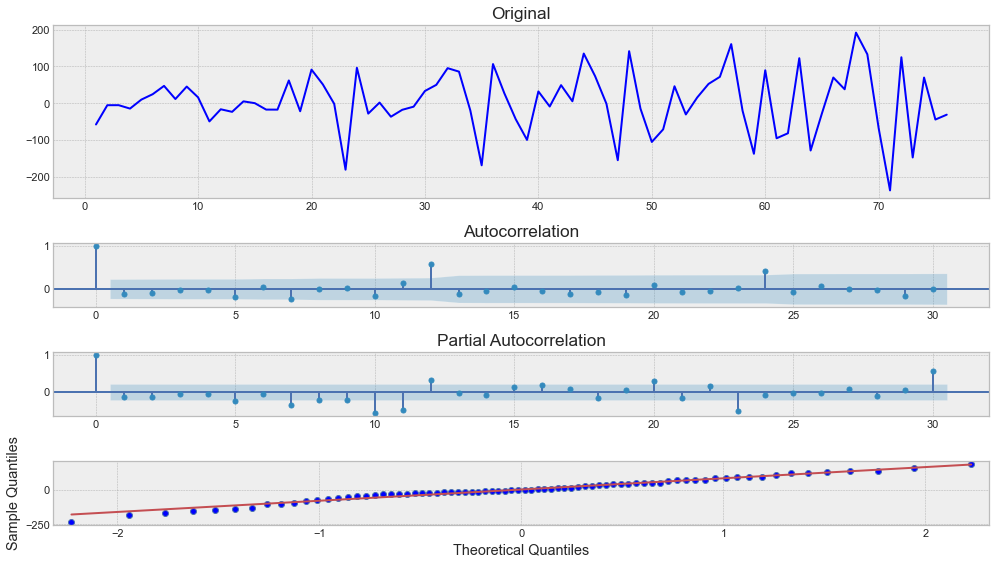

In [130]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(jan_df, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
print('P-value для стационарности:', adfuller(best_mdl.resid, autolag='AIC')[1])

tsplot(best_mdl.resid, lags=30)

## Итог: 
* Наш самописный грид-сёрч справился с задачей, остатки распределены в виде нормлаьного шума
* Модель ARIMA выходит что смогла решить задачу

## Далее реализуем приведение ряда к стационарности и обратно

<AxesSubplot:>

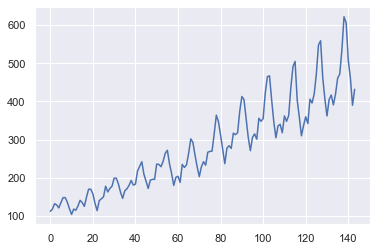

In [133]:
series_original = pd.read_csv("international-airline-passengers.csv")['Count']
series_original.plot()

<AxesSubplot:>

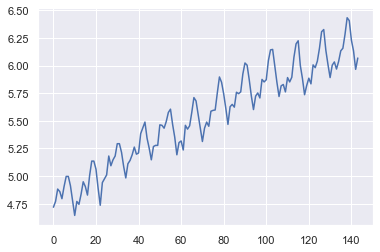

In [134]:
### Бокс-Кокс
series = pd.Series(boxcox(series_original, 0))
series.plot()

<AxesSubplot:>

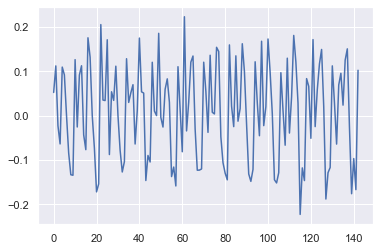

In [135]:
### убираем тренд
series = np.diff(series)
pd.Series(series).plot()

In [136]:
### убираем сезонность
seasion = series[:-12]
series = series[12:] - seasion

<AxesSubplot:>

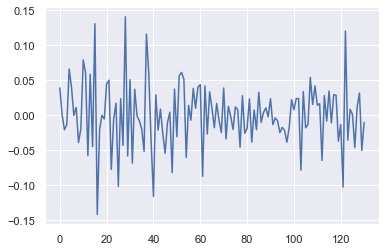

In [137]:
series = pd.Series(series)
series.plot()

* **Вот такой ряд получили, теперь вернем его обратно в исходный вид**

<AxesSubplot:>

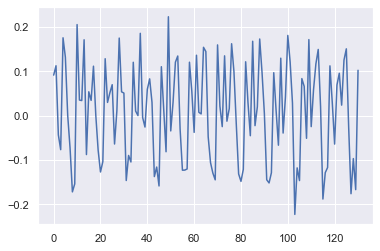

In [138]:
### возвращаемся к сезонности, это получилось, можно сравнить с графиком выше
### мы находимся в той же шклае, в которой и были
proba = series + seasion
proba.plot()

<AxesSubplot:>

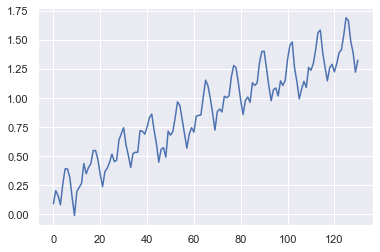

In [139]:
### теперь вернем тренд
### график совпадает с исходным после Бокса-Кокса, за исключением шкалы
proba =  pd.Series(np.cumsum(proba))
proba.plot()

<AxesSubplot:>

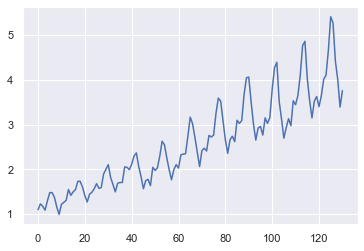

In [140]:
### А теперь избавимся от Бокса-Кокса
proba = pd.Series(np.exp(proba))
proba.plot()

<AxesSubplot:>

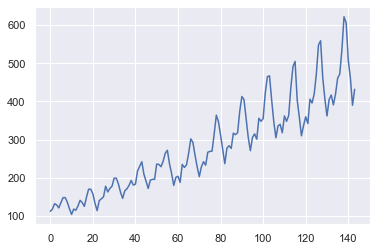

In [142]:
### Оригинал
series_original.plot()

In [143]:
print(len(series_original))
print(len(proba))

144
131


## Итог возвращения:
* По форме графика мы вернулись в исходное состояние
* **Но мы не вернулись в исходну шкалу, эту проблему неясно как решать, возникла она на этапе возвращения тренда**
* У них и размерность разная, так что как привести возращенный график к исходному мне неясно